[Python For Finance: Algorithmic Trading (article) - DataCamp](https://www.datacamp.com/community/tutorials/finance-python-trading)

+ 简单的动量策略
+ 测试,pandas, zipline and quantopian
+ 优化，评估策略表现及其稳定性      

## 简单的策略-动量策略和反转策略


+  动量策略也称为趋势策略。使用该策略意味你相信当前的趋势为延续。也就是发现上涨或下跌趋势，并进行跟随投资。
 
    + 比如利用股票价格的移动平均线进行投资： 
       + 当一个移动平均线穿越另一个移动平均线时，就进行操作。穿越的交叉点代表动量改变的点。在这个时间点可以买入或者卖出。 
       + 当一个较短时间窗口的移动平均线穿越一个较长时间窗的平均线时，代表较短时间窗平均线代表的趋势获得确认。从下往上穿越时是买入信号，从上往下穿越是卖出信号。

    + 海龟交易法，当一个资产创20日新高时买入，创20日新低时卖出。

+ 反转策略。这种策略认为偏离常态的资产会逐渐回归到常态。
    + 最简单的是均值反转策略，即当一个资产的价格总会回到其均值。 
    + 另一种常用的反转策略是配对交易。配对交易考虑两个资产，认为他们的价格差回均值回复。也就是说当他们的价差有一个期望，当实际价差大于期望时，他们的价格会靠拢而减少差距。 （分析情况）
 
+  基于预测的策略, 基于统计或机器学习方法，预测价格变化的趋势，比如基于决策树模型对未来一个月上涨的概率进行预测，当概率大于0.8时买入或持有多头，但小于0.2时卖出或持有空头。
 

### 实现移动平均线策略

  
我们可以用如下步骤实现这个策略。首先导入包和数据

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
os.chdir("D:\\teaching\\Windexport")
datat=pd.read_excel("indexdaily.xlsx", index_col=[0,2])

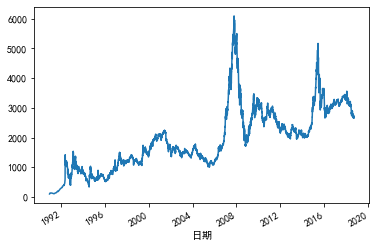

In [3]:
plt.rcParams['font.sans-serif'] = ['SimHei']  # 中文字体设置  
plt.rcParams['axes.unicode_minus'] = False  

Pclose=datat.loc["000001.SH","收盘价"] 
Pclose.plot()

+ 定义两个不同的时间窗口，比如10日（两周）和20日（月），60日（季度），120日（半年）等 .
 

In [4]:
# Initialize the short and long windows
short_window =20
long_window = 120

+ 生成一个新的空 DataFrame,用来存储信号，让该DataFrame和价格序列的index相同，给信号赋初值0    

In [5]:
Pclose.head()

日期
1990-12-19     99.98
1990-12-20    104.39
1990-12-21    109.13
1990-12-24    114.55
1990-12-25    120.25
Name: 收盘价, dtype: float64

In [6]:

# Initialize the `signals` DataFrame with the `signal` column
signals = pd.DataFrame(index=Pclose.index)
signals['signal'] = 0.0


In [7]:
signals.head()

,signal
日期,
1990-12-19,0.0
1990-12-20,0.0
1990-12-21,0.0
1990-12-24,0.0
1990-12-25,0.0


+   使用rolling 函数计算滑动平均     

In [8]:

# Create short simple moving average over the short window
signals['short_mavg'] = Pclose.rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = Pclose.rolling(window=long_window, min_periods=1, center=False).mean()


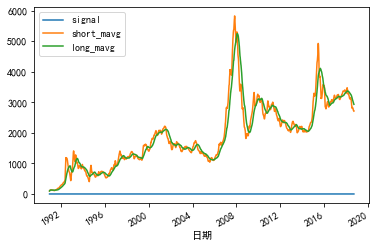

In [9]:
signals.plot()

+  生成信号， 短窗口滑动平均大于长窗口滑动平均


In [10]:

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] 
                                            > signals['long_mavg'][short_window:], 1.0, 0.0)   



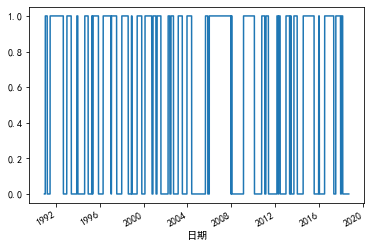

In [11]:
signals['signal'].plot() 

+  最后，通过diff寻找信号改变的时间，得到交易指令. 

+ 通过该数值，可以判断买卖，做空还是做多。

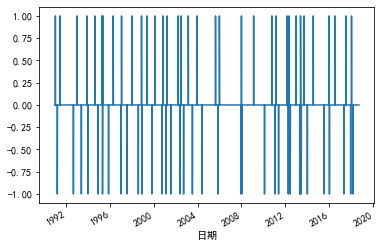

In [12]:
# Generate trading orders
signals['positions'] = signals['signal'].diff()
signals['positions'].plot()
# Print `signals`
#print(signals)

In [13]:
signals['positions']

日期
1990-12-19    NaN
1990-12-20    0.0
1990-12-21    0.0
1990-12-24    0.0
1990-12-25    0.0
             ... 
2018-09-12    0.0
2018-09-13    0.0
2018-09-14    0.0
2018-09-17    0.0
2018-09-18    0.0
Name: positions, Length: 6789, dtype: float64

+ 画出滑动平均值和买卖信号 

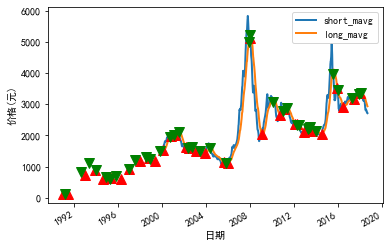

In [14]:
 
# Initialize the plot figure
fig = plt.figure()

# Add a subplot and label for y-axis
ax1 = fig.add_subplot(111,  ylabel='价格(元)')

# Plot the closing price
#Pclose["2005":"2010"].plot(ax=ax1, color='r', lw=2.)

# Plot the short and long moving averages
signals[['short_mavg', 'long_mavg']]["2000":"2018"].plot(ax=ax1, lw=2.)

# Plot the buy signals
ax1.plot(signals.loc[signals.positions == 1.0].index, 
         signals.short_mavg[signals.positions == 1.0],
         '^', markersize=10, color='red')
         
# Plot the sell signals
ax1.plot(signals.loc[signals.positions == -1.0].index, 
         signals.short_mavg[signals.positions == -1.0],
         'v', markersize=10, color='green')
         
# Show the plot
plt.show()

## 策略回测


+ 回测就是用历史数据来检验我们对策略，分析盈利和风险。
+ 回测结果可能需要考虑各种外部因素影响。 比如监管政策、宏观经济时间、流动性限制（禁止卖空)。

In [15]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)


In [16]:
# Buy a 100 shares
positions['Pclose'] = 100*signals['signal']  


In [17]:
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(Pclose, axis=0)
portfolio

,Pclose
日期,
1990-12-19,0.0
1990-12-20,0.0
1990-12-21,0.0
1990-12-24,0.0
1990-12-25,0.0
...,...
2018-09-12,0.0
2018-09-13,0.0
2018-09-14,0.0


In [18]:
# Store the difference in shares owned 
pos_diff = positions.diff()


In [19]:
pos_diff

,Pclose
日期,
1990-12-19,NaN
1990-12-20,0.0
1990-12-21,0.0
1990-12-24,0.0
1990-12-25,0.0
...,...
2018-09-12,0.0
2018-09-13,0.0
2018-09-14,0.0


In [20]:
# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(Pclose, axis=0)).sum(axis=1)
portfolio['holdings']

日期
1990-12-19    0.0
1990-12-20    0.0
1990-12-21    0.0
1990-12-24    0.0
1990-12-25    0.0
             ... 
2018-09-12    0.0
2018-09-13    0.0
2018-09-14    0.0
2018-09-17    0.0
2018-09-18    0.0
Name: holdings, Length: 6789, dtype: float64

In [21]:
# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(Pclose, axis=0)).sum(axis=1).cumsum()   

In [22]:
# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

# Print the first lines of `portfolio`
print(portfolio.tail())

            Pclose  holdings       cash      total  returns
日期                                                         
2018-09-12     0.0       0.0  589054.58  589054.58      0.0
2018-09-13     0.0       0.0  589054.58  589054.58      0.0
2018-09-14     0.0       0.0  589054.58  589054.58      0.0
2018-09-17     0.0       0.0  589054.58  589054.58      0.0
2018-09-18     0.0       0.0  589054.58  589054.58      0.0


+ 可视化测试结果

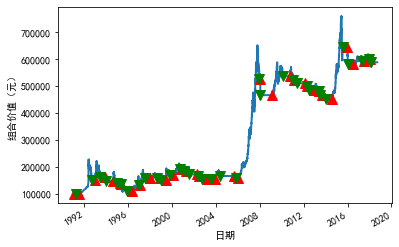

In [23]:
# Import the `pyplot` module as `plt`
import matplotlib.pyplot as plt

# Create a figure
fig = plt.figure()

ax1 = fig.add_subplot(111, ylabel='组合价值（元）')

# Plot the equity curve in dollars
portfolio['total'].plot(ax=ax1, lw=2.)

ax1.plot(portfolio.loc[signals.positions == 1.0].index, 
         portfolio.total[signals.positions == 1.0],
         '^', markersize=10, color='red')
ax1.plot(portfolio.loc[signals.positions == -1.0].index, 
         portfolio.total[signals.positions == -1.0],
         'v', markersize=10, color='green')

# Show the plot
plt.show()

+ 计算sharpe比

In [24]:

# Isolate the returns of your strategy
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(sharpe_ratio)



0.45088912993803043


最大回撤

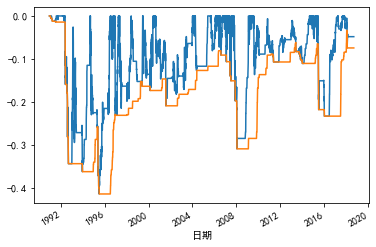

In [25]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day
rolling_max = portfolio['total'].rolling(window, min_periods=1).max()
daily_drawdown = portfolio['total']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

+ 年化收益率

In [26]:
# Get the number of days in `aapl`
days = (portfolio['total'].index[-1] - portfolio['total'].index[0]).days

# Calculate the CAGR 
cagr = ((((portfolio['total'][-1]) / portfolio['total'][1])) ** (365.0/days)) - 1

# Print CAGR
print(cagr)

0.06594853706449788



+ Trading & Backtesting

    +  **TA-Lib** – TA-Lib is widely used by trading software developers requiring to perform technical analysis of financial market data. It has an open-source API for python.
    + trade – trade is a Python framework for the development of financial applications. A trade app works like a service. The user informs the items he has in stock and a series of subsequent occurrences (purchases, sales, whatsoever) with those or other items. trade then calculates the effects of those occurrences and gives back the new amounts and costs of the items in stock.
    + **zipline** – Zipline is a Pythonic algorithmic trading library. It is an event-driven system that supports both backtesting and live trading.
    + QuantSoftware Toolkit – Python-based open source software framework designed to support portfolio construction and management. It is built the QSToolKit primarily for finance students, computing students, and quantitative analysts with programming experience.
    + quantitative – Quantitative finance, and backtesting library. Quantitative is an event driven and versatile backtesting library.
    + analyzer – Python framework for real-time financial and backtesting trading strategies
    + bt – bt is a flexible backtesting framework for Python used to test quantitative trading strategies.
    + backtrader – Python Backtesting library for trading strategies
    + pybacktest – Vectorized backtesting framework in Python / pandas, designed to make your backtesting easier. It allows users to specify trading strategies using full power of pandas, at the same time hiding all boring things like manually calculating trades, equity, performance statistics and creating visualizations. Resulting strategy code is usable both in research and production setting.
    + pyalgotrade – PyAlgoTrade is an event driven algorithmic trading Python library. Although the initial focus was on backtesting, paper trading is now possible
    + tradingWithPython – A collection of functions and classes for Quantitative trading
    + pandas_talib – A Python Pandas implementation of technical analysis indicators
    + algobroker – This is an execution engine for algo trading. The idea is that this python server gets requests from clients and then forwards them to the broker API.
    + finmarketpy – finmarketpy is a Python based library that enables you to analyze market data and also to backtest trading strategies using a simple to use API, which has prebuilt templates for you to define backtest.
 